## Example of metric calculation using moving object metrics.

The inputs needed here (the obsfile) can be calculated using the code demonstrated in the [ExampleMoObs](./ExampleMoObs.ipynb) notebook. 

Here, I'm working through how those observations can be read back into the code and metric values (such as discovery chances and then completeness) can be calculated. 

There are definitely some things to be improved upon; if the observation generation stopped at the point of generating interpolations, for example, and the moving object slicer read those interpolations back in, together with the the simdata, it could generate the actual observations on the fly (when using the camera footprint, this would add non-insignificant overhead, so it might actually be nice to be able to do either/both). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from moSlicer import MoSlicer
import moMetrics as MoMetrics

In [2]:
# Set up MoSlicer. 
orbitfile = 'pha20141031.des'
obsfile = 'pha_withChip_allObs.txt'

In [3]:
mos = MoSlicer(orbitfile, Hrange=np.arange(13, 25, 0.5))
mos.readObs(obsfile)
mos.allObs.tail(20)

,objId,delta,ra,dec,magV,time,dradt,ddecdt,phase,solarelon,...,rotSkyPos,filter,finSeeing,fiveSigmaDepth,visitExpTime,solarElong,dmagColor,dmagTrailing,dmagDetect,magFilter
498465,1509,3.807585,232.162482,-13.867993,26.807897,52812.959487,-0.135164,0.023399,7.739730,141.960484,...,2.067869,z,0.591825,22.345612,30,142.582521,-0.298076,0.017964,0.006627,26.509822
498466,1509,3.836297,231.764230,-13.800000,26.846965,52815.977878,-0.125938,0.020567,8.294546,138.719931,...,2.139164,u,0.815799,23.826715,30,139.728399,1.614403,0.008231,0.009221,28.461368
498467,1509,3.856936,231.511279,-13.758995,26.872889,52818.026284,-0.119632,0.018756,8.654165,136.535920,...,2.490199,i,0.802486,23.893487,30,137.789771,-0.291352,0.007622,0.009684,26.581537
498468,1509,3.857142,231.508800,-13.758617,26.873143,52818.046393,-0.119652,0.018837,8.657686,136.514350,...,2.405117,i,0.790631,23.924198,30,137.770613,-0.291352,0.007874,0.009486,26.581791
498469,1509,3.899094,231.066736,-13.692126,26.921466,52821.964452,-0.105546,0.014484,9.304559,132.376038,...,2.089832,y,0.651985,21.514407,30,131.338842,-0.302563,0.009023,0.008689,26.618903
498470,1509,3.945141,230.671198,-13.640637,26.969350,52825.979612,-0.091460,0.010377,9.910644,128.189480,...,2.080238,z,0.650129,23.220739,30,127.523521,-0.298076,0.006628,0.010552,26.671275
498471,1509,3.945326,230.669707,-13.640473,26.969537,52825.995473,-0.091585,0.010426,9.912962,128.173005,...,2.038979,z,0.639866,23.255766,30,127.508406,-0.298076,0.006888,0.010311,26.671461
498472,1509,4.059989,229.994709,-13.586697,27.072252,52835.133881,-0.057398,0.001587,11.068826,118.861983,...,5.723259,y,0.613642,21.724412,30,118.821957,-0.302563,0.002207,0.016753,26.769688
498473,1509,4.125030,229.766478,-13.593334,27.122748,52839.956698,-0.040178,-0.004076,11.551571,114.071994,...,2.350935,z,0.807953,22.029138,30,114.235451,-0.298076,0.000000,0.024918,26.824672
498474,1509,4.196550,229.619714,-13.626012,27.173249,52845.060689,-0.021372,-0.008650,11.968122,109.089030,...,3.884269,i,0.631296,24.138357,30,109.373800,-0.291352,0.000000,0.027931,26.881897


In [4]:
mos.orbits.tail()

,H,M,a,argPeri,e,epoch,g,inc,node,objId,q,tPeri
1505,20,77.366479,0.827048,180.468630,0.261660,49353.16,0.15,18.671330,196.578930,1505,1.043454,49294.121282
1506,20,4110.999168,0.501293,254.126570,0.677470,49353.16,0.15,5.860190,230.397840,1506,0.840904,47872.781068
1507,20,550.437461,0.733294,182.128100,0.324399,49353.16,0.15,40.010180,45.448550,1507,0.971174,49002.478210
1508,20,495.166011,0.325984,286.820640,0.728317,49353.16,0.15,6.578750,6.006240,1508,0.563404,49259.655236
1509,20,2040.128826,0.558708,234.119532,0.667609,49353.16,0.15,4.725926,183.610507,1509,0.931707,48488.743387


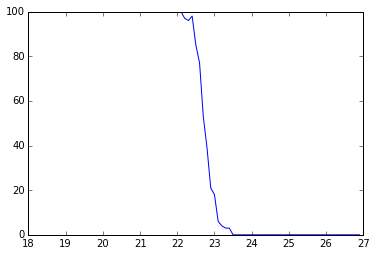

In [5]:
### side note..
metric = MoMetrics.BaseMoMetric()
# Check what 'visibility' looks like. 
appMag = np.arange(18, 27, 0.001)
magLim = 22.8
vis = metric._calcVis(appMag, magLim)
bins = np.arange(appMag.min(), appMag.max(), 0.1)
counts = np.zeros(len(bins))
for i, (b1, b2) in enumerate(zip(bins[:-1], bins[1:])):
    counts[i] = len(np.where((appMag >= b1) & (appMag < b2) & (vis==1))[0])
plt.plot(bins, counts)

In [6]:
metric1 = MoMetrics.NObsMetric()

In [7]:
metricVals1 = np.zeros(mos.slicerShape, float)
for i, slicept in enumerate(mos):
    for j, Hval in enumerate(slicept['Hvals']):
        metricVals1[i][j] = metric1.run(slicept['obs'], slicept['orb'], Hval)

In [10]:
print i
print metricVals1[1509]

1509
[ 703.  703.  702.  685.  637.  569.  503.  468.  428.  344.  231.  142.
  101.   70.   44.   37.   26.   18.   11.    4.    0.    0.    0.    0.]
